In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
import pickle
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
student_info = pd.read_csv('/content/drive/MyDrive/365_learning_challenge/365_database/365_database/365_student_info.csv')
student_purchases = pd.read_csv('/content/drive/MyDrive/365_learning_challenge/365_database/365_database/365_student_purchases.csv')
student_learning = pd.read_csv('/content/drive/MyDrive/365_learning_challenge/365_database/365_database/365_student_learning.csv')
course_info = pd.read_csv('/content/drive/MyDrive/365_learning_challenge/365_database/365_database/365_course_info.csv')
course_ratings = pd.read_csv('/content/drive/MyDrive/365_learning_challenge/365_database/365_database/365_course_ratings.csv')
student_quizzes = pd.read_csv('/content/drive/MyDrive/365_learning_challenge/365_database/365_database/365_student_quizzes.csv')
quiz_info = pd.read_csv('/content/drive/MyDrive/365_learning_challenge/365_database/365_database/365_quiz_info.csv')
student_exams = pd.read_csv('/content/drive/MyDrive/365_learning_challenge/365_database/365_database/365_student_exams.csv')
exam_info = pd.read_csv('/content/drive/MyDrive/365_learning_challenge/365_database/365_database/365_exam_info.csv')
student_engagement = pd.read_csv('/content/drive/MyDrive/365_learning_challenge/365_database/365_database/365_student_engagement.csv')
student_hub_questions = pd.read_csv('/content/drive/MyDrive/365_learning_challenge/365_database/365_database/365_student_hub_questions.csv')

In [ ]:
st_count_ct_wise = pd.DataFrame(student_info.groupby(['student_country'])['student_id'].count())
st_count_ct_wise

,student_id
student_country,
AD,2
AE,250
AF,5
AG,1
AL,22
...,...
XK,3
YE,30
ZA,311


**Getting Insight from Data**
*Student_Info*

In [ ]:
fig = px.bar(st_count_ct_wise, x=st_count_ct_wise.nlargest(35,'student_id').index, y=st_count_ct_wise.nlargest(35,'student_id').values.reshape(-1))
fig.show()

In [ ]:
fig = px.bar(st_count_ct_wise, x=st_count_ct_wise.nlargest(5,'student_id').index, y=st_count_ct_wise.nlargest(5,'student_id').values.reshape(-1))
fig.show()

In [ ]:
course_rating_info = course_ratings.merge(course_info,how='left',on='course_id')
course_rating_score = pd.DataFrame(course_rating_info.groupby(['course_title'])['course_rating'].sum())
course_rating_score['count_of_rating'] = pd.DataFrame(course_rating_info.groupby(['course_title'])['course_rating'].count())
course_rating_score['average_rating'] = course_rating_score['course_rating']/course_rating_score['count_of_rating']

pd.DataFrame(course_rating_score['average_rating'].sort_values(ascending=False))

,average_rating
course_title,
Customer Analytics in Python,5.000000
SQL + Tableau + Python,5.000000
Git and GitHub,4.975610
Introduction to Jupyter,4.929825
Data Preprocessing with NumPy,4.903226
Introduction to R Programming,4.880000
Dates and Times in Python,4.875000
Advanced Microsoft Excel,4.860000
Introduction to Data and Data Science,4.858392


In [ ]:
course_rating_score['average_rating'].mean()

4.667995504420836

**Student Learning** 
*Sum minutes*

In [ ]:
tot_min_watched = pd.DataFrame(student_learning.groupby(['course_id'])['minutes_watched'].sum()).merge(course_info,how='left',on='course_id')

In [ ]:
tot_min_watched = tot_min_watched.set_index('course_id')
tot_min_watched = tot_min_watched.sort_values(by='minutes_watched',ascending=False)

In [ ]:
tot_min_watched.head()

,minutes_watched,course_title
course_id,,
7,333265.9,Introduction to Data and Data Science
14,234824.8,SQL
21,193279.6,Statistics
23,164472.1,Introduction to Excel
16,155164.3,Python Programmer Bootcamp


In [ ]:
fig = px.bar(tot_min_watched, x=tot_min_watched.index, y="minutes_watched",
             hover_data=["course_title","minutes_watched"], color='minutes_watched',title="Minutes watched in each course id",height=400)
fig.show()

In [ ]:
student_info['date_registered'] = pd.to_datetime(student_info['date_registered'],dayfirst=True)
student_info['date_registered_10'] = student_info['date_registered'] + timedelta(days=10)
student_learning_updated = student_learning.merge(student_info,how='left',on='student_id')
student_learning_updated = student_learning_updated[student_learning_updated['date_watched'] >= student_learning_updated['date_registered_10']]

total_courses = pd.DataFrame(student_learning_updated.groupby(['student_id'])['course_id'].count())
minutes_watched = pd.DataFrame(student_learning_updated.groupby(['student_id'])['minutes_watched'].sum())
student_learning_updated = total_courses.merge(minutes_watched,how='left',on='student_id')

student_learning_updated.sort_values(by=["minutes_watched"],inplace=True,ascending=False)
Top_student_minutes_watched=student_learning_updated.head(10)
Top_student_minutes_watched

,course_id,minutes_watched
student_id,,
269204,146,7046.3
272842,50,6893.6
268926,115,6466.7
272909,83,6313.2
264146,115,6138.1
275045,77,5970.6
261682,130,5885.9
276439,78,5376.8
268011,102,5335.5


In [ ]:
fig = px.pie(Top_student_minutes_watched, names=Top_student_minutes_watched.index, values="minutes_watched",hover_data=["course_id"],height=400)
fig.show()

**Student Exams**

In [ ]:
student_exams_updated = student_exams.merge(student_info,how='left',on='student_id')
student_exams_updated = student_exams_updated[student_exams_updated['date_exam_completed']>=student_exams_updated['date_registered_10']]

total_attempts = pd.DataFrame(student_exams_updated.groupby(['student_id'])['exam_attempt_id'].count())
average_result = pd.DataFrame(student_exams_updated.groupby(['student_id'])['exam_result'].mean())

Text(0.5, 0, 'Average_Exam_Result')

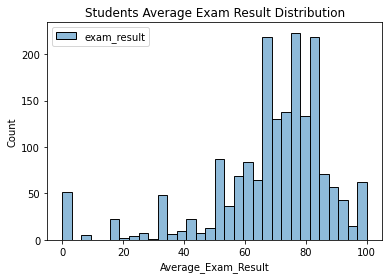

In [ ]:
sns.histplot(average_result)
plt.title('Students Average Exam Result Distribution')
plt.xlabel('Average_Exam_Result')

In [ ]:
student_exams_updated = total_attempts

**Student purchases**

In [ ]:
purchased = pd.DataFrame(student_purchases.groupby(['student_id'])['purchase_id'].count())

Text(0, 0.5, 'Count Of Students')

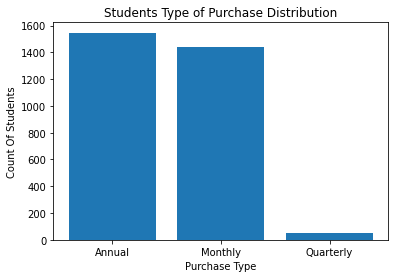

In [ ]:
plt.bar(student_purchases['purchase_type'].value_counts().keys(),student_purchases['purchase_type'].value_counts())
plt.title('Students Type of Purchase Distribution')
plt.xlabel('Purchase Type')
plt.ylabel('Count Of Students')

In [ ]:
student_exams_updated = total_attempts

**Student Engagement**

In [ ]:
student_engagement_updated = student_engagement.merge(student_info,how='left',on='student_id')
student_engagement_updated = student_engagement_updated[student_engagement_updated['date_engaged']>=student_engagement_updated['date_registered_10']]

total_engagement = pd.DataFrame(student_engagement_updated.groupby(['student_id'])['engagement_id'].count())

Text(0.5, 0, 'Total Engagement')

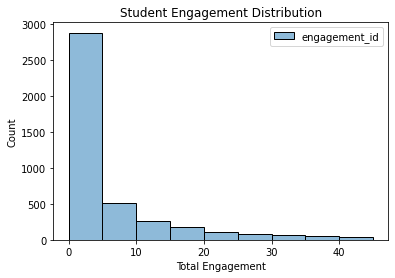

In [ ]:
sns.histplot(total_engagement,bins=np.arange(0,50,5))
plt.title('Student Engagement Distribution')
plt.xlabel('Total Engagement')

In [ ]:
engagement_quzzies = pd.DataFrame(student_engagement_updated.groupby(['student_id'])['engagement_quizzes'].sum())
engagement_exams = pd.DataFrame(student_engagement_updated.groupby(['student_id'])['engagement_exams'].sum())
engagement_lessons = pd.DataFrame(student_engagement_updated.groupby(['student_id'])['engagement_lessons'].sum())

student_engagement_updated = total_engagement.merge(engagement_quzzies,how='left',on='student_id').merge(engagement_exams,how='left',on='student_id').merge(engagement_lessons,how='left',on='student_id')

**Student Hub questions**

In [ ]:
student_hub_questions_updated = student_hub_questions.merge(student_info,how='left',on='student_id')
student_hub_questions_updated = student_hub_questions_updated[student_hub_questions_updated['date_question_asked']>=student_hub_questions_updated['date_registered_10']]

total_hub_questions = pd.DataFrame(student_hub_questions_updated.groupby(['student_id'])['hub_question_id'].count())
student_hub_questions_updated = total_hub_questions

In [ ]:
student_hub_questions_updated.shape[0],student_engagement_updated.shape[0],student_exams_updated.shape[0],student_learning_updated.shape[0],purchased.shape[0]

(212, 4349, 1848, 4300, 2135)

In [ ]:
student_engagement_data = student_engagement_updated.merge(student_learning_updated,how='left',on='student_id').merge(purchased,how='left',on='student_id').merge(student_hub_questions_updated,how='left',on='student_id').merge(student_exams_updated,how='left',on='student_id')

In [ ]:
student_info_updated = student_info.merge(student_engagement_data,how='left',on='student_id')

In [ ]:
student_info_updated.rename(columns={'engagement_id': 'total_engagement',
                                   'course_id':'total_courses','exam_attempt_id':'total_exam_attempts',
                                    'purchase_id':'total_purchases'}, inplace=True)

In [ ]:
student_info_updated['student_country'] = student_info_updated['student_country'].fillna(student_info_updated['student_country'].mode().iloc[0])

In [ ]:
features = student_info_updated.select_dtypes(include='float64').columns
for i in features:
    student_info_updated[i] = student_info_updated[i].fillna(0)

In [ ]:
student_info_updated['purchased'] = student_info_updated['total_purchases']

In [ ]:
student_info_updated['engagement_quizzes'] = np.where(student_info_updated['engagement_quizzes'] > 0,
                                    1,student_info_updated['engagement_quizzes'])
student_info_updated['engagement_exams'] = np.where(student_info_updated['engagement_exams'] > 0,
                                    1,student_info_updated['engagement_exams'])
student_info_updated['engagement_lessons'] = np.where(student_info_updated['engagement_lessons'] > 0,
                                    1,student_info_updated['engagement_lessons'])
student_info_updated['hub_question_id'] = np.where(student_info_updated['hub_question_id'] > 0,
                                    1,student_info_updated['hub_question_id'])
student_info_updated['purchased'] = np.where(student_info_updated['purchased'] > 0,
                                    1,student_info_updated['purchased'])

In [ ]:
student_info_updated['engagement_quizzes'] = student_info_updated['engagement_quizzes'].astype('int')
student_info_updated['engagement_exams'] = student_info_updated['engagement_exams'].astype('int')
student_info_updated['engagement_lessons'] = student_info_updated['engagement_lessons'].astype('int')
student_info_updated['hub_question_id'] = student_info_updated['hub_question_id'].astype('int')
student_info_updated['total_engagement'] =student_info_updated['total_engagement'].astype('int')
student_info_updated['total_courses'] =student_info_updated['total_courses'].astype('int')
student_info_updated['total_exam_attempts'] =student_info_updated['total_exam_attempts'].astype('int')
student_info_updated['purchased'] =student_info_updated['purchased'].astype('int')
student_info_updated['total_purchases'] =student_info_updated['total_purchases'].astype('int')

In [ ]:
student_info_updated.head()

,student_id,student_country,date_registered,date_registered_10,total_engagement,engagement_quizzes,engagement_exams,engagement_lessons,total_courses,minutes_watched,total_purchases,hub_question_id,total_exam_attempts,purchased
0,258798,IN,2022-01-01,2022-01-11,0,0,0,0,0,0.0,0,0,0,0
1,258799,CO,2022-01-01,2022-01-11,0,0,0,0,0,0.0,0,0,0,0
2,258800,CA,2022-01-01,2022-01-11,22,1,1,1,22,304.3,1,0,2,1
3,258801,IN,2022-01-01,2022-01-11,0,0,0,0,0,0.0,0,0,0,0
4,258802,US,2022-01-01,2022-01-11,0,0,0,0,0,0.0,0,0,0,0


In [ ]:
correlation = student_info_updated.corr()
k = 10
cols = correlation.nlargest(k,'purchased')['purchased']
corr_feat = pd.DataFrame(cols)
corr_feat.columns = ['Correlation Ratio']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'features')

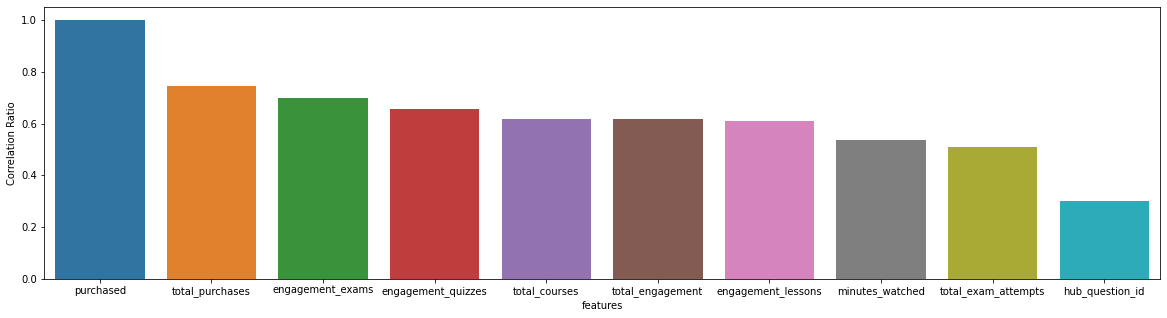

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(corr_feat.index,corr_feat['Correlation Ratio'])
plt.xlabel('features')

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(36,36), dpi = 480)
sns.heatmap(student_info_updated.corr(), annot = True, fmt = '.2f')

In [ ]:
student_info_updated['purchased'].value_counts(1)
purchased_ = len(student_info_updated[student_info_updated['purchased'] == 1])
not_purchased_ = len(student_info_updated[student_info_updated['purchased'] == 0])
purchased_ratio = purchased_/not_purchased_
purchased_ratio * 100

5.198721968407536

In [ ]:
student_info_updated = student_info_updated.set_index('student_id')

In [ ]:
le = LabelEncoder()
le.fit(student_info_updated['student_country'])
student_info_updated['student_country'] = le.fit_transform(student_info_updated['student_country'])

In [ ]:
features_cols = ['student_country','total_engagement', 'engagement_quizzes', 'engagement_exams',
       'engagement_lessons', 'total_courses', 'minutes_watched',
       'total_purchases', 'total_exam_attempts', 'hub_question_id',
       'purchased']
student_info_updated = student_info_updated[features_cols]

In [ ]:
x = student_info_updated.drop('purchased',axis=1)
y = student_info_updated['purchased']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1234)

In [ ]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Instantiate TPOTClassifier
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(x_train, y_train)

# AUC score for tpot model
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(x_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')

# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=2, min_samples_leaf=12, min_samples_split=7)

AUC score: 1.0000

Best pipeline steps:
1. DecisionTreeClassifier(max_depth=2, min_samples_leaf=12, min_samples_split=7,
                       random_state=42)


In [ ]:
# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=2, min_samples_leaf=12, min_samples_split=7,
                       random_state=42)
# Fit dt to the training set
dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=12, min_samples_split=7,
                       random_state=42)

In [ ]:
y_pred = dt.predict(x_test)

In [ ]:
print(classification_report(y_test,y_pred,target_names=['not_purchased','purchased']))
print(accuracy_score(y_test,y_pred)*100)

               precision    recall  f1-score   support

not_purchased       1.00      1.00      1.00      8380
    purchased       1.00      1.00      1.00       428

     accuracy                           1.00      8808
    macro avg       1.00      1.00      1.00      8808
 weighted avg       1.00      1.00      1.00      8808

100.0


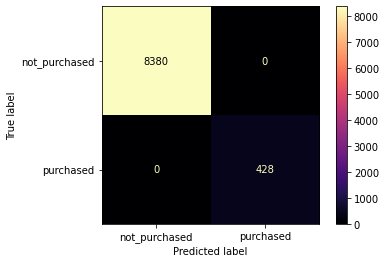

In [ ]:
sns.reset_orig()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['not_purchased','purchased'])
disp.plot(cmap='magma',colorbar=True)

In [ ]:
pickle.dump(dt,open('Model_365_Data_Challenge.pickle','wb'))

In [ ]:
model = pickle.load(open('Model_365_Data_Challenge.pickle', 'rb'))

In [ ]:
model.predict(pd.DataFrame([[75,0,1,2,5,0,0,1,2,1]]))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



array([1])